## Introduction
Where did data come from?

The material id needs to be prepended by "mp-". The job is performed below

In [18]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join(''))
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
# print (module_path)

# from utils.editdf import EditFile 

# ed = EditFile()
# ed.generateFile('assets/HalfHeusler.csv', 'assets/Heusler compound.csv')


In [19]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import os.path
import pandas as pd

path_to_file = 'assets/HalfHeusler.csv'
file_name = 'assets/Heusler compound.csv'

if (not os.path.exists(file_name)):
    print ("A formatted csv file is produced\n")
    df = pd.read_csv(path_to_file)
    print (df.head())

    id_list = df['Materials-ID'].to_list()

    n = df.columns[0]
    df.drop(n, axis=1, inplace=True)

    df[n] = ["mp-" + str(x) for x in id_list]
    print (df.head())

    df.to_csv(file_name, index = False)

- Lattice parameters, atomic radii and atomic masses. The atomic radius is calculated value and not the empirical values
- Python library 'pymatgen'

In [29]:
'''
The Element class is located in the core subpakage inside the periodic_table module. 
The link to the API documentation is below.

    https://pymatgen.org/pymatgen.core.periodic_table.html#pymatgen.core.periodic_table.Element

Similarly the material project APIs are hosted in the following module.

    https://pymatgen.org/pymatgen.ext.matproj.html?highlight=mprester#module-pymatgen.ext.matproj
'''
# %pip install pymatgen

import pymatgen.core as pg
from pymatgen.ext.matproj import MPRester
from math import sqrt
import sys

file_name_train = 'assets/Training data.csv'

if (not os.path.exists(file_name_train)):
    print ("Training data will be generated\n")

    heusler_df = pd.read_csv(file_name, header=0, usecols= ['Materials-ID', '4a-site', '4b-site', '4c-site'])
    data = []

    m = MPRester('fmdc9tZK1xE74JOq')
    for idx in heusler_df.index:
        mat_data = m.get_data(heusler_df['Materials-ID'][idx])
        lat = m.get_structure_by_material_id(heusler_df['Materials-ID'][idx])
        
        lat_const = lat.lattice.abc
        mag_moment = sum(lat.site_properties['magmom'])
        
        e1 = pg.Element(heusler_df['4a-site'][idx])
        e2 = pg.Element(heusler_df['4b-site'][idx])
        e3 = pg.Element(heusler_df['4c-site'][idx])

        x1 = e1.atomic_radius
        x2 = e2.atomic_radius
        x3 = e3.atomic_radius
        m1 = e1.atomic_mass
        m2 = e2.atomic_mass
        m3 = e3.atomic_mass
        
        
        x29 = m1+m2+m3
        x30 = x1+x2+x3
        x33 = (x29/3 -m1)
        x34 = (x29/3 -m2)
        x35 = (x29/3 -m3)
        x42 = (x30/3 -x1)
        x43 = (x30/3 -x2)
        x44 = (x30/3 -x3)
        x51 = (x1**2 + x2**2)
        x52 = (x1**2 + x3**2)
            
        data.append((x1,x2,x3,m1,m2,m3,m1**2,m2**2,m3**2,x1**2,x2**2,x3**2,
                     m1**3,m2**3,m3**3,x1**3,x2**3,x3**3,
                     sqrt(m1),sqrt(m2),sqrt(m3),sqrt(x1),sqrt(x2),sqrt(x3),
                     m2/m1, x3/m1, x2/x1,x3/x1, x29,x30,
                     ((m1**2+m2**2+m3**2)/3.)**2, ((x1**2+x2**2+x3**2)/3.)**2,
                     x33, x34, x35, abs(x33), abs(x34), abs(x35), x33**2, x34**2, x35**2,
                     x42, x43, x44, abs(x42), abs(x43), abs(x44), x42**2, x43**2, x44**2,
                     x51, x52,sqrt(x51), sqrt(x52), 
                     mat_data[0]["formation_energy_per_atom"], # mag_moment,
                     lat_const[0], lat_const[1], lat_const[2]
                    ))

    idx = []
    for i in range(1, 55):
        idx.append('x'+str(i))

#     idx.extend(['form_energy_per_atom', 'total_magnetic_moment','a', 'b', 'c'])
    idx.extend(['form_energy_per_atom','a', 'b', 'c'])
    df_train = pd.DataFrame(data, columns = idx)

    df_train.to_csv(file_name_train, index = False)

ImportError: ignored

## Machine Learning
The gradient boosted trees are selected for the regression task. The cross-validation is the first step.

### Scaling
Use MinMaxScaler

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# 
# df = pd.read_csv('assets/Training data.csv')
# 
# X = df.iloc[:, :-3]
# y = df.iloc[:, -1]
# 
# print  (X.head())
# print  (y.head())
# 
# trans = MinMaxScaler()
# X = trans.fit_transform(X)


### Cross-Validation
A five fold cross validation will be performed for the better performance of the model.

In [28]:
# %pip install sklearn

from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

df = pd.read_csv('assets/Training data.csv')
X = df.iloc[:, :-3]
y = df.iloc[:, -1]

k = 5
kf = KFold(n_splits=k)
scoreR2 = []
y_pred = []

# gbReg = GradientBoostingRegressor(loss = 'lad', n_estimators=1600, max_depth= 8, random_state= 44)
gbReg = GradientBoostingRegressor(loss = 'lad', n_estimators=700, max_depth= 18, random_state= 44)

for train_idx, test_idx in kf.split(X):
#     X_train, X_test = X[train_idx, :], X[test_idx, :]
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    gbReg.fit(X_train, y_train)
    y_pred.extend(gbReg.predict(X_train))
    
    scoreR2.append(gbReg.score(X_test, y_test))
    
print (sum(scoreR2)/k)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbReg.fit(X_train, y_train)
print (gbReg.score(X_test, y_test))

0.8575876900175384
0.9153343661809036


## Grid Search
Hyperparameter tuning

Best: 0.858979 using {'max_depth': 20, 'n_estimators': 1000}


The score for best estimator: 

0.9138863847605647


0.748037 (0.082492) with: {'max_depth': 14, 'n_estimators': 100}
0.813889 (0.083656) with: {'max_depth': 14, 'n_estimators': 400}
0.817546 (0.081200) with: {'max_depth': 14, 'n_estimators': 700}
0.817880 (0.080910) with: {'max_depth': 14, 'n_estimators': 1000}
0.794467 (0.047507) with: {'max_depth': 16, 'n_estimators': 100}
0.844090 (0.029258) with: {'max_depth': 16, 'n_estimators': 400}
0.850788 (0.030193) with: {'max_depth': 16, 'n_estimators': 700}
0.851002 (0.030252) with: {'max_depth': 16, 'n_estimators': 1000}
0.803967 (0.059758) with: {'max_depth': 18, 'n_estimators': 100}
0.851981 (0.038788) with: {'max_depth': 18, 'n_estimators': 400}
0.857588 (0.036626) with: {'max_depth': 18, 'n_estimators': 700}
0.857707 (0.036724) with: {'max_depth': 18, 'n_estimators': 1000}
0.803967 (0.059758) with: {'max_depth': 20, 'n_estimators': 100}
0.852594 (0.037929) with: {'max_dept

Text(0, 0.5, 'R2 score')

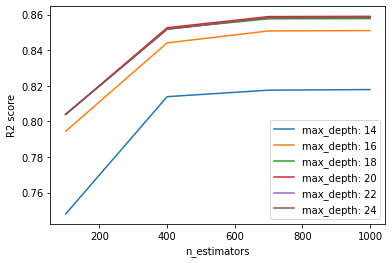

In [24]:
# %pip install numpy
# %pip install matplotlib

from sklearn.model_selection import GridSearchCV
import numpy as np
from matplotlib import pyplot
%matplotlib inline

max_depth = [14, 16,18,20,22,24]
n_estimators = [100, 400, 700, 1000]
learning_rate = [0.09, 0.1, 0.11, 0.12]
param_grid = dict(max_depth=max_depth, n_estimators= n_estimators)

grid_search = GridSearchCV(gbReg, param_grid, scoring="r2", n_jobs=-1, cv=kf)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print ("\n")

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Fit the best estimator 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = grid_result.best_estimator_
best_model.fit(X_train, y_train)
print ("The score for best estimator: \n")
print (best_model.score(X_test, y_test))

print ("\n")

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='max_depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('R2 score')

'\n    lr =0.1\n    max_depth= 18 or 20\n    n_estimators= 1200-1600\n'

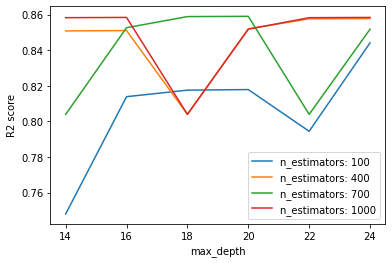

In [25]:
scores = np.array(means).reshape(len(n_estimators),len(max_depth))
for i, value in enumerate(n_estimators):
    pyplot.plot(max_depth, scores[i], label='n_estimators: ' + str(value))
pyplot.legend()
pyplot.xlabel('max_depth')
pyplot.ylabel('R2 score')

'''
    lr =0.1
    max_depth/n_estimators= 16/1000 or 20/700 or 18/700
'''